In [ ]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import csv

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#проверяем наличие доступного графического процессора (GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Если GPU доступен, переменной device присваивается значение 'cuda', что означает использование GPU для вычислений. 
Если GPU недоступен, переменной device присваивается значение 'cpu', что означает использование центрального процессора (CPU) для вычислений.

In [ ]:
device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## 1. Классификация фамилий (RNN)

Датасет: https://disk.yandex.ru/d/frNchuaBQVLxyA?w=1

Рекуррентный — значит возвращающийся. RNN угадывает следующие слова в тексте или ноты в мелодии, возвращаясь к своим прошлым догадкам. Прошлые догадки нейросеть хранит как вектор активации нейронов и передает с шага на шаг.

In [ ]:
#Считать файл surnames/surnames.csv.
surnames = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/surnames/surnames.csv')
surnames

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian
...,...,...
10975,Quraishi,Arabic
10976,Innalls,English
10977,Król,Polish
10978,Purvis,English


In [ ]:
# Закодировать национальности числами, начиная с 0
# преобразование представляет собой однозначное соответствие число - уникальное значение категориального признака

labelencoder = LabelEncoder()
surnames['nationality class'] = labelencoder.fit_transform(surnames['nationality'])
# обучаем кодировщик на уникальных значениях в столбце 'nationality' и затем преобразуем эти значения в числовые метки классов
surnames

,surname,nationality,nationality class
0,Woodford,English,4
1,Coté,French,5
2,Kore,English,4
3,Koury,Arabic,0
4,Lebzak,Russian,14
...,...,...,...
10975,Quraishi,Arabic,0
10976,Innalls,English,4
10977,Król,Polish,12
10978,Purvis,English,4


In [ ]:
# Разбить датасет на обучающую и тестовую выборку
X = surnames['surname']
y = surnames['nationality class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [ ]:
# Реализовать класс Vocab (токен = символ)
# класс который предоставляет словарные объекты для обработки естественного языка
class Vocab:
    def __init__(self, data):
        #это словарь, где ключами являются токены (буквы или символы), а значениями - их индексы
        self.token_to_idx = {'<PAD>': 0} #в словарь добавляется специальный токен <PAD> с индексом 0
        self.max_seq_len = 0 #атрибут, который хранит длину самой длинной последовательности из набора данных
        index = 1
        for surname in data['surname']: #происходит итерация по каждой фамилии
            if len(surname) > self.max_seq_len:
                self.max_seq_len = len(surname)
            for letter in surname: #происходит вложенная итерация по каждой букве в фамилии
                if letter not in self.token_to_idx:
                    self.token_to_idx[letter] = index #добавляется в словарь с индексом index
                    index += 1
        self.vocab_len = index #self.vocab_len получает значение index, что является общим количеством уникальных токенов (букв и символов) в словаре

In [ ]:
vocabulary = Vocab(surnames)
vocabulary.token_to_idx['W'] # возвращает индекс, связанный с токеном 'W'

1

In [ ]:
# Реализовать класс SurnamesDataset
class SurnamesDataset(Dataset):
    def __init__(self, X, y, vocab: Vocab): #конструктор класса
        self.X = X #признаки
        self.y = y #метки
        self.vocab = vocab

    def vectorize(self, surname): #метод, который преобразует фамилию в последовательность индексов токенов
        indexes = []
        pad_index = self.vocab.token_to_idx['<PAD>'] #тут 0
        count_pad = self.vocab.max_seq_len - len(surname) #длина каждой такой последовательности должна быть одинаковой и равной vocab.max_seq_len.
        #итерирует по каждой букве в фамилии и использует словарь self.vocab для получения соответствующего индекса каждого токена
        for letter in surname:
            index = self.vocab.token_to_idx[letter]
            indexes.append(index)
        for i in range(count_pad): #Чтобы добиться этого, дополните последовательность справа индексом токена <PAD> до нужной длины
            indexes.append(pad_index)
        return indexes
    
    def __len__(self): #метод, который возвращает общее количество элементов в наборе данных
        return len(self.X)

    def __getitem__(self, idx): #метод, который возвращает элемент набора данных по индексу idx
        x_surname = torch.tensor(self.vectorize(self.X.iloc[idx])) #преобразует фамилии (self.X.iloc[idx]) в последовательность индексов токенов
        y_surname = torch.tensor(self.y.iloc[idx]) #преобразует соответствующую метку (self.y.iloc[idx]) в тензоры PyTorch
        return (x_surname, y_surname)

In [ ]:
#создаем экземпляры класса SurnamesDataset для обучающего и тестового наборов данных
surnames_dataset_train = SurnamesDataset(X_train, y_train, vocabulary)
surnames_dataset_test = SurnamesDataset(X_test, y_test, vocabulary)

In [ ]:
print(list(vocabulary.token_to_idx)) #выводим список токенов, которые были добавлены в словарь
print()
print(surnames_dataset_train.X.iloc[0]) #обращаемся к первой фамилии в обучающем наборе данных surnames_dataset_train.X и выводим ее значение
surnames_dataset_train[0] #возввращаем пару значений (x_surname, y_surname), выводя тензор

['<PAD>', 'W', 'o', 'd', 'f', 'r', 'C', 't', 'é', 'K', 'e', 'u', 'y', 'L', 'b', 'z', 'a', 'k', 'O', 'i', 'n', 'R', 'h', 'l', 'Z', 'A', 'c', 'M', 's', 'v', 'E', 'p', 'm', 'V', 'I', 'G', 'S', 'B', 'J', 'D', 'g', 'P', 'H', 'w', 'Y', 'T', 'j', 'F', "'", 'N', 'q', 'U', 'Q', 'à', 'x', 'ü', '-', 'í', 'ú', 'ä', 'X', 'ö', 'ó', '1', 'ò', 'ñ', 'Ż', 'ß', 'á', 'è', 'ã', 'ê', 'ì', 'Ś', 'É', 'ż', 'ń', 'ù', 'ç', '/', 'Á', 'õ', 'ą', 'ł', ':']

Lowe


(tensor([13,  2, 43, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 tensor(4))

In [ ]:
batch_size = 64 #задаем размер пакета, то есть количество примеров, которые будут загружены одновременно на каждой итерации обучения или оценки модели
train_loader = DataLoader(surnames_dataset_train, shuffle=True, batch_size=batch_size) #создаем загрузчик данных для обучающего набора данных
#shuffle=True (случайное перемешивание данных перед каждой эпохой обучения)
test_loader = DataLoader(surnames_dataset_test, shuffle=True, batch_size=batch_size) #создаем загрузчик данных для тестового набора данных

1.1 Используя класс `nn.RNNCell` (абстракцию для отдельного временного шага RNN), реализуйте простейшую рекуррентную сеть Элмана в виде класса `RNN`. Используя созданный класс `RNN`, решите задачу классификации фамилий. 


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size): #конструктор класса, который принимает два аргумента: размер входных данных и размер скрытого состояния RNN
        super(RNN, self).__init__() #вызываем конструктор родительского класса nn.Module
        self.rnn_cell = nn.RNNCell(input_size, hidden_size) #инициализируем атрибут rnn_cell

    def forward(self, x, h=None): #метод, который определяет прямой проход (forward pass) модели
        x = x.transpose(1, 0) #тензор x транспонируется
        all_h = []
        for batch_character in x:
            # проходим по каждому элементу последовательности в пакете и обновляем скрытое состояние h
            h = self.rnn_cell.forward(batch_character, h)
            all_h.append(h) #добавляем в список 

        return torch.stack(all_h, dim=0).transpose(1, 0), h # метод возвращает тензор всех наблюдавшихся скрытых состояний
        # torch.stack(all_h, dim=0) объединяет все скрытые состояния вдоль измерения 0, создавая тензор размера (seq_len, batch_size, hidden_size)
        # transpose(1, 0) транспонирует размерности 0 и 1, чтобы получить размерность (batch_size, seq_len, hidden_size)
        
        '''
        x.shape = (batch_size, seq_len, feature_size) - тензор входных данных до transpose
        h.shape = (batch_size, hidden_size) - тензор со скрытым состоянием RNN 
        '''

In [ ]:
n_classes = surnames['nationality class'].nunique() #определяет количество уникальных значений в столбце

class SurnamesNet(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(SurnamesNet, self).__init__()
        #слой эмбеддингов (nn.Embedding) с размером словаря num_embeddings=vocabulary.vocab_len и размерностью эмбеддингов embedding_dim
        self.emb = nn.Embedding(num_embeddings=vocabulary.vocab_len, embedding_dim=embedding_dim) 
        self.rnn = RNN(input_size=embedding_dim, hidden_size=hidden_size) #экземпляр класса RNN, созданный с параметрами input_size=embedding_dim и hidden_size=hidden_size
        self.fc = torch.nn.Linear(hidden_size, n_classes) #полносвязный слой (nn.Linear) с размерностью входа hidden_size и размерностью вывода n_classes
        
    def forward(self, x):
        x = self.emb(x) #x проходит через слой эмбеддингов self.emb, где каждый индекс токена заменяется на соответствующий эмбеддинг
        
        #полученные эмбеддинги передаются в рекуррентную нейронную сеть self.rnn
        output, h_n = self.rnn(x) #output представляет собой тензор всех скрытых состояний на каждом временном шаге, а h_n - последнее скрытое состояние RNN
        
        #последние скрытые состояния передаются через полносвязный слой self.fc
        x = self.fc(output[:, -1]) #извлекаем только последнее скрытое состояние для каждого примера в пакете
        return x

In [ ]:
#создаем объект модели SurnamesNet с размерностью эмбеддингов 256 и размером скрытого состояния 512
net = SurnamesNet(256, 512)
net = net.to(device) #перемещаем модель на указанное устройство 

In [ ]:
loss = nn.CrossEntropyLoss() #создаем объект функции потерь, которая будет использоваться для вычисления потери модели 
optimizer = optim.Adam(net.parameters(), lr=0.0001) #создаем оптимизатор Adam, который будет использоваться для обновления параметров модели в процессе обучения

n_epochs = 100
losses = []
for epoch in range(n_epochs): #происходит итерация по эпохам обучения
    loss_value = 0
    for X, y in train_loader:
        #перемещаем входные данные и метки классов
        X = X.to(device)
        y = y.to(device)
        y_pred = net.forward(X) #вызываем метод forward модели net для выполнения прямого прохода и получения предсказаний модели y_pred
        loss_tensor = loss.forward(y_pred, y) #вычисляем значение функции потерь между предсказаниями модели y_pred и истинными метками классов y
        loss_tensor.backward() #вычисляем градиенты функции потерь по параметрам модели
        optimizer.step() #обновляет параметры модели, применение градиента
        optimizer.zero_grad() #обнуляем градиенты всех параметров модели перед следующей итерацией обновления
        loss_value += loss_tensor.item() #накапливаем значение функции потерь для текущего пакета в переменной
    losses.append(loss_value) #сохраняем значение функции потерь на текущей эпохе в список losses
    print(f'epoch {epoch} loss {loss_value}') #выводим текущий номер эпохи и значение функции потерь на этой эпохе

epoch 0 loss 313.52623188495636
epoch 1 loss 309.17796564102173
epoch 2 loss 276.9112069606781
epoch 3 loss 255.5772670507431
epoch 4 loss 236.7849110364914
epoch 5 loss 228.03531742095947
epoch 6 loss 221.48516654968262
epoch 7 loss 213.34253704547882
epoch 8 loss 203.07772970199585
epoch 9 loss 198.81135392189026
epoch 10 loss 189.2820245027542
epoch 11 loss 179.21442914009094
epoch 12 loss 173.3301859498024
epoch 13 loss 170.94306582212448
epoch 14 loss 161.16221034526825
epoch 15 loss 162.8452318906784
epoch 16 loss 154.93923836946487
epoch 17 loss 152.5479421019554
epoch 18 loss 148.65941905975342
epoch 19 loss 143.35241055488586
epoch 20 loss 142.00183981657028
epoch 21 loss 138.84430420398712
epoch 22 loss 134.73604935407639
epoch 23 loss 134.7004622220993
epoch 24 loss 131.50443315505981
epoch 25 loss 125.67422837018967
epoch 26 loss 124.53834873437881
epoch 27 loss 121.80015552043915
epoch 28 loss 124.96033817529678
epoch 29 loss 118.42075419425964
epoch 30 loss 117.4390285015

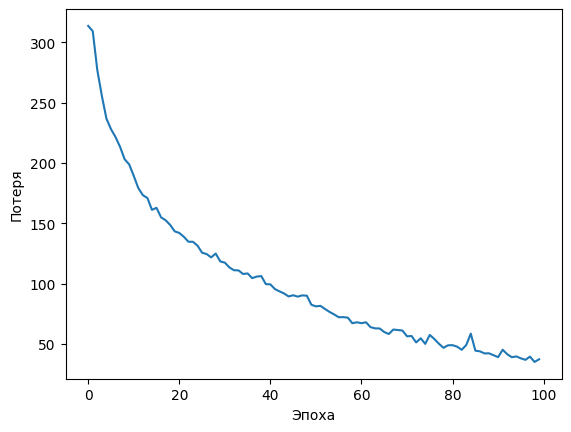

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.show()

In [ ]:
# Проверить работоспособность модели
correct = 0
for X, y in test_loader:
    X = X.to(device)
    y = y.to(device)
    #вызываем метод forward модели net для выполнения прямого прохода и получения предсказаний модели label_pred
    label_pred = net.forward(X).argmax(dim=1) #метод argmax(dim=1) выбирает индекс класса с наибольшей вероятностью для каждого примера
    #увеличиваем значение переменной correct на количество правильно классифицированных примеров в текущем пакете данных
    correct += (label_pred == y).sum()

#вычисляем точность модели, разделив общее количество правильно классифицированных примеров (correct) на размер тестового набора данных (len(surnames_dataset_test))
accuracy = correct / len(surnames_dataset_test)
print('значение accuracy на тестовом множестве:', accuracy)

значение accuracy на тестовом множестве: tensor(0.7127, device='cuda:0')


1.2 Замените модуль `RNN` из 1.1 на модули `nn.RNN`, `nn.LSTM` и `nn.GRU` (не забудьте указать аргумент `batch_first=True`). Сравните результаты работы.

In [ ]:
#nn.RNN
n_classes = surnames['nationality class'].nunique()

class SurnamesNet(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(SurnamesNet, self).__init__()
        self.emb = nn.Embedding(num_embeddings=vocabulary.vocab_len, embedding_dim=embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True) 
        self.fc = torch.nn.Linear(hidden_size, n_classes)
        
    def forward(self, x):
        x = self.emb(x)
        output, h_n = self.rnn(x)
        x = self.fc(output[:, -1])
        return x

In [ ]:
net = SurnamesNet(256, 512)
net = net.to(device)

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

n_epochs = 100
losses = []
for epoch in range(n_epochs):
    loss_value = 0
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        y_pred = net.forward(X)
        loss_tensor = loss.forward(y_pred, y)
        loss_tensor.backward() #градиент
        optimizer.step() #применение градиента
        optimizer.zero_grad()
        loss_value += loss_tensor.item()
    losses.append(loss_value)
    print(f'epoch {epoch} loss {loss_value}')

epoch 0 loss 310.9856264591217
epoch 1 loss 298.84139800071716
epoch 2 loss 270.5870393514633
epoch 3 loss 254.55175924301147
epoch 4 loss 235.82371616363525
epoch 5 loss 222.76350486278534
epoch 6 loss 213.78754913806915
epoch 7 loss 205.44985562562943
epoch 8 loss 191.1575562953949
epoch 9 loss 183.68300604820251
epoch 10 loss 178.3667431473732
epoch 11 loss 172.50378823280334
epoch 12 loss 168.1871336698532
epoch 13 loss 159.09910184144974
epoch 14 loss 153.24533760547638
epoch 15 loss 147.20483124256134
epoch 16 loss 145.17016077041626
epoch 17 loss 138.66525602340698
epoch 18 loss 137.21004974842072
epoch 19 loss 131.90712070465088
epoch 20 loss 131.14268362522125
epoch 21 loss 125.0638080239296
epoch 22 loss 120.9915561079979
epoch 23 loss 119.54565992951393
epoch 24 loss 121.91791558265686
epoch 25 loss 115.95699322223663
epoch 26 loss 111.38488560914993
epoch 27 loss 111.94583135843277
epoch 28 loss 108.70161566138268
epoch 29 loss 109.59748202562332
epoch 30 loss 105.269030064

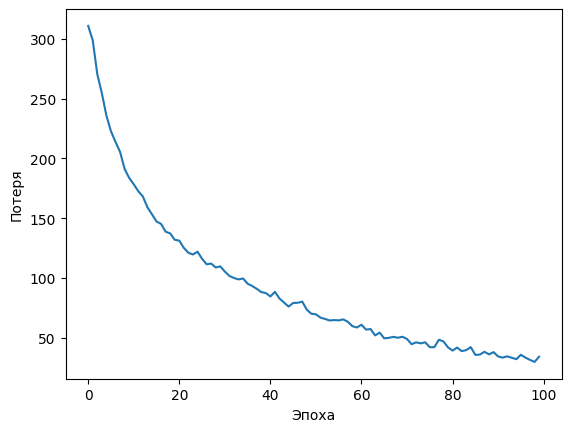

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.show()

In [ ]:
# Проверить работоспособность модели
correct = 0
for X, y in test_loader:
    X = X.to(device)
    y = y.to(device)
    label_pred = net.forward(X).argmax(dim=1)
    correct += (label_pred == y).sum()

accuracy = correct / len(surnames_dataset_test)
print('значение accuracy на тестовом множестве:', accuracy)

значение accuracy на тестовом множестве: tensor(0.7186, device='cuda:0')


LSTM специально разработаны для устранения проблемы долгосрочной зависимости.

In [ ]:
#nn.LSTM
n_classes = surnames['nationality class'].nunique()

class SurnamesNetLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(SurnamesNetLSTM, self).__init__()
        self.emb = nn.Embedding(num_embeddings=vocabulary.vocab_len, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True) 
        self.fc = torch.nn.Linear(hidden_size, n_classes)
        
    def forward(self, x):
        x = self.emb(x)
        output, (h_n, c_n) = self.lstm(x)
        x = self.fc(output[:, -1])
        return x

In [ ]:
net1 = SurnamesNetLSTM(256, 512)
net1 = net1.to(device)

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net1.parameters(), lr=0.0001)

n_epochs = 100
losses = []
for epoch in range(n_epochs):
    loss_value = 0
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        y_pred = net1.forward(X)
        loss_tensor = loss.forward(y_pred, y)
        loss_tensor.backward() #градиент
        optimizer.step() #применение градиента
        optimizer.zero_grad()
        loss_value += loss_tensor.item()
    losses.append(loss_value)
    print(f'epoch {epoch} loss {loss_value}')

epoch 0 loss 309.0698297023773
epoch 1 loss 250.42533361911774
epoch 2 loss 206.66878777742386
epoch 3 loss 173.41102278232574
epoch 4 loss 151.3469745516777
epoch 5 loss 139.3511860370636
epoch 6 loss 127.4844462275505
epoch 7 loss 118.8945614695549
epoch 8 loss 112.67226701974869
epoch 9 loss 106.19201213121414
epoch 10 loss 99.94139191508293
epoch 11 loss 96.72630649805069
epoch 12 loss 91.19594100117683
epoch 13 loss 85.8362523317337
epoch 14 loss 82.08691334724426
epoch 15 loss 79.10549333691597
epoch 16 loss 73.92024083435535
epoch 17 loss 70.3706046640873
epoch 18 loss 69.80093486607075
epoch 19 loss 64.19397175312042
epoch 20 loss 60.54816776514053
epoch 21 loss 58.57301799952984
epoch 22 loss 53.488182842731476
epoch 23 loss 50.63859222829342
epoch 24 loss 48.94947624206543
epoch 25 loss 45.525938898324966
epoch 26 loss 43.030924156308174
epoch 27 loss 41.426648303866386
epoch 28 loss 37.71593526750803
epoch 29 loss 38.02233873307705
epoch 30 loss 33.496336199343204
epoch 31 l

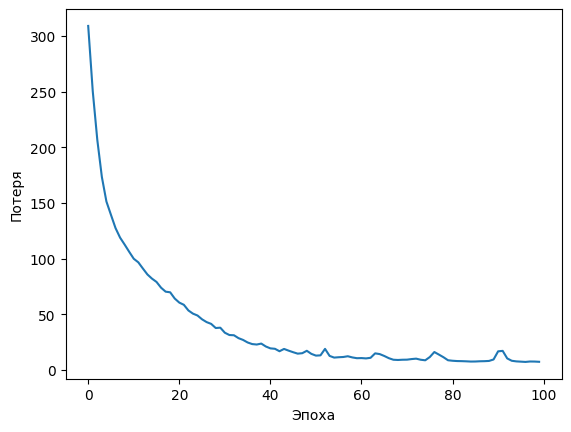

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.show()

In [ ]:
# Проверить работоспособность модели
correct = 0
for X, y in test_loader:
    X = X.to(device)
    y = y.to(device)
    label_pred = net1.forward(X).argmax(dim=1)
    correct += (label_pred == y).sum()

accuracy = correct / len(surnames_dataset_test)
print('значение accuracy на тестовом множестве:', accuracy)

значение accuracy на тестовом множестве: tensor(0.7623, device='cuda:0')


GRU является одной из архитектур рекуррентных нейронных сетей (RNN) и используется для моделирования последовательностей данных.

GRU является модификацией стандартной рекуррентной нейронной сети LSTM (Long Short-Term Memory). Он имеет более простую структуру, но сохраняет способность моделировать долгосрочные зависимости в последовательностях. GRU состоит из нескольких гейтов (ворот) и состояния скрытого слоя, которые позволяют управлять информацией, сохраняемой и передаваемой внутри сети.

In [ ]:
#nn.GRU
n_classes = surnames['nationality class'].nunique()

class SurnamesNet(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(SurnamesNet, self).__init__()
        self.emb = nn.Embedding(num_embeddings=vocabulary.vocab_len, embedding_dim=embedding_dim)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True) 
        self.fc = torch.nn.Linear(hidden_size, n_classes)
        
    def forward(self, x):
        x = self.emb(x)
        output, h_n = self.gru(x)
        x = self.fc(output[:, -1])
        return x

In [ ]:
net = SurnamesNet(256, 512)
net = net.to(device)

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

n_epochs = 100
losses = []
for epoch in range(n_epochs):
    loss_value = 0
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        y_pred = net.forward(X)
        loss_tensor = loss.forward(y_pred, y)
        loss_tensor.backward() #градиент
        optimizer.step() #применение градиента
        optimizer.zero_grad()
        loss_value += loss_tensor.item()
    losses.append(loss_value)
    print(f'epoch {epoch} loss {loss_value}')

epoch 0 loss 291.50634038448334
epoch 1 loss 220.73912674188614
epoch 2 loss 181.36855340003967
epoch 3 loss 159.27288883924484
epoch 4 loss 142.673137485981
epoch 5 loss 129.45703744888306
epoch 6 loss 120.0987120270729
epoch 7 loss 113.01150700449944
epoch 8 loss 105.68203416466713
epoch 9 loss 100.47231814265251
epoch 10 loss 95.60120105743408
epoch 11 loss 93.2699670791626
epoch 12 loss 87.43329134583473
epoch 13 loss 83.11268693208694
epoch 14 loss 79.64660856127739
epoch 15 loss 76.70251634716988
epoch 16 loss 72.78783364593983
epoch 17 loss 69.29758179187775
epoch 18 loss 67.50647160410881
epoch 19 loss 63.56234276294708
epoch 20 loss 60.12532365322113
epoch 21 loss 58.35708098113537
epoch 22 loss 55.375110283493996
epoch 23 loss 52.67520093917847
epoch 24 loss 50.17065070569515
epoch 25 loss 47.48181387037039
epoch 26 loss 45.28787298500538
epoch 27 loss 44.16473979502916
epoch 28 loss 41.07553696632385
epoch 29 loss 39.8750833645463
epoch 30 loss 38.188206017017365
epoch 31 lo

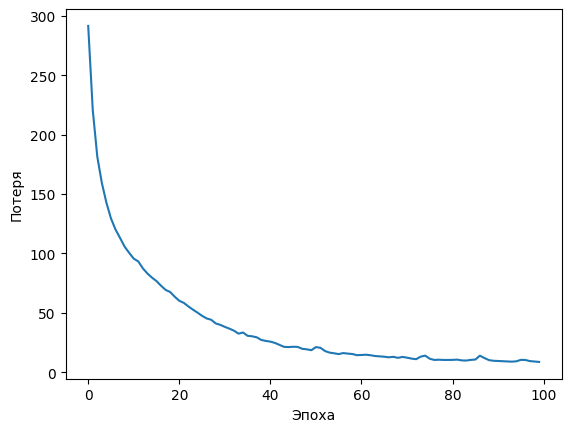

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.show()

In [ ]:
# Проверить работоспособность модели
correct = 0
for X, y in test_loader:
    X = X.to(device)
    y = y.to(device)
    label_pred = net.forward(X).argmax(dim=1)
    correct += (label_pred == y).sum()

accuracy = correct / len(surnames_dataset_test)
print('значение accuracy на тестовом множестве:', accuracy)

значение accuracy на тестовом множестве: tensor(0.7559, device='cuda:0')


1.3 Загрузите предобученные эмбеддинги (https://disk.yandex.ru/d/BHuT2tEXr_yBOQ?w=1) в модуль `nn.Embedding` и обучите модели из 1.2.

In [ ]:
# Путь к файлу
file_path = '/content/drive/MyDrive/Colab Notebooks/embeddings/glove.6B.50d.txt'
# Считываем файл
embeddings = pd.read_csv(file_path, sep=" ", header=None, quoting=3, encoding='utf-8', engine='python')
print(embeddings)

                0         1         2        3         4        5         6   \
0              the  0.418000  0.249680 -0.41242  0.121700  0.34527 -0.044457   
1                ,  0.013441  0.236820 -0.16899  0.409510  0.63812  0.477090   
2                .  0.151640  0.301770 -0.16763  0.176840  0.31719  0.339730   
3               of  0.708530  0.570880 -0.47160  0.180480  0.54449  0.726030   
4               to  0.680470 -0.039263  0.30186 -0.177920  0.42962  0.032246   
...            ...       ...       ...      ...       ...      ...       ...   
399995      chanty  0.232040  0.025672 -0.70699 -0.045465  0.13989 -0.628070   
399996      kronik -0.609210 -0.672180  0.23521 -0.111950 -0.46094 -0.007462   
399997     rolonda -0.511810  0.058706  1.09130 -0.551630 -0.10249 -0.126500   
399998     zsombor -0.758980 -0.474260  0.47370  0.772500 -0.78064  0.232330   
399999  sandberger  0.072617 -0.513930  0.47280 -0.522020 -0.35534  0.346290   

              7         8         9   .

In [ ]:
rows = vocabulary.vocab_len
columns = 50
embeddings_surnames = torch.zeros(rows, columns) #создаем тензор заданного размера, заполненный нулями
embeddings_surnames

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
for i, token in enumerate(embeddings[0]):
    if token in vocabulary.token_to_idx: 
        embeddings_surnames[vocabulary.token_to_idx[token]] = torch.tensor(embeddings.iloc[i, 1:].tolist())
embeddings_surnames

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0439,  1.3183, -0.0371,  ..., -0.8627,  1.2377,  0.8743],
        ...,
        [-0.7893,  0.1091, -0.5975,  ...,  0.6855, -0.3955,  0.5643],
        [ 0.4479, -0.1347,  0.7468,  ...,  0.7457,  0.5642,  0.3913],
        [-0.1759,  1.3508, -0.1816,  ...,  0.1562,  0.5665,  0.6138]])

In [ ]:
#rnn
n_classes = surnames['nationality class'].nunique()

class SurnamesNet(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(SurnamesNet, self).__init__()
        self.emb = nn.Embedding.from_pretrained(embeddings_surnames)
        self.rnn = nn.RNN(input_size=columns, hidden_size=hidden_size, batch_first=True) 
        self.fc = torch.nn.Linear(hidden_size, n_classes)
        
    def forward(self, x):
        x = self.emb(x)
        output, h_n = self.rnn(x)
        x = self.fc(output[:, -1])
        return x

In [ ]:
net = SurnamesNet(256, 512)
net = net.to(device)

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

n_epochs = 100
losses = []
for epoch in range(n_epochs):
    loss_value = 0
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        y_pred = net.forward(X)
        loss_tensor = loss.forward(y_pred, y)
        loss_tensor.backward() #градиент
        optimizer.step() #применение градиента
        optimizer.zero_grad()
        loss_value += loss_tensor.item()
    losses.append(loss_value)
    print(f'epoch {epoch} loss {loss_value}')

epoch 0 loss 297.11079919338226
epoch 1 loss 271.21585726737976
epoch 2 loss 252.3176691532135
epoch 3 loss 244.73892724514008
epoch 4 loss 226.32346105575562
epoch 5 loss 213.21365630626678
epoch 6 loss 206.74296629428864
epoch 7 loss 192.41034322977066
epoch 8 loss 179.02780175209045
epoch 9 loss 169.9899365901947
epoch 10 loss 163.34293925762177
epoch 11 loss 153.20813238620758
epoch 12 loss 146.20519387722015
epoch 13 loss 138.62689888477325
epoch 14 loss 135.26209884881973
epoch 15 loss 130.63138949871063
epoch 16 loss 122.33755600452423
epoch 17 loss 116.75938358902931
epoch 18 loss 111.57283279299736
epoch 19 loss 108.53970646858215
epoch 20 loss 101.64951729774475
epoch 21 loss 97.67732095718384
epoch 22 loss 91.93297165632248
epoch 23 loss 88.6213566660881
epoch 24 loss 83.51178649067879
epoch 25 loss 78.34497585892677
epoch 26 loss 76.70754784345627
epoch 27 loss 67.73756454885006
epoch 28 loss 65.67450308799744
epoch 29 loss 61.12728200852871
epoch 30 loss 57.73344914615154


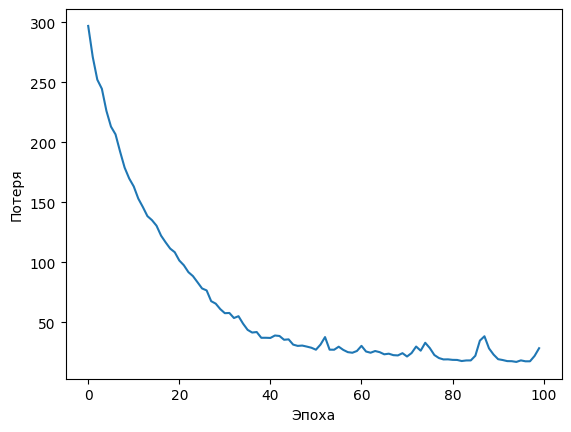

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.show()

In [ ]:
# Проверить работоспособность модели
correct = 0
for X, y in test_loader:
    X = X.to(device)
    y = y.to(device)
    label_pred = net.forward(X).argmax(dim=1)
    correct += (label_pred == y).sum()

accuracy = correct / len(surnames_dataset_test)
print('значение accuracy на тестовом множестве:', accuracy)

значение accuracy на тестовом множестве: tensor(0.6799, device='cuda:0')


In [ ]:
#lstm
n_classes = surnames['nationality class'].nunique()

class SurnamesNetLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(SurnamesNetLSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(embeddings_surnames)
        self.lstm = nn.LSTM(input_size=columns, hidden_size=hidden_size, batch_first=True) 
        self.fc = torch.nn.Linear(hidden_size, n_classes)
        
    def forward(self, x):
        x = self.emb(x)
        output, (h_n, c_n) = self.lstm(x)
        x = self.fc(output[:, -1])
        return x

In [ ]:
net1 = SurnamesNetLSTM(256, 512)
net1 = net1.to(device)

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net1.parameters(), lr=0.0005)

n_epochs = 100
losses = []
for epoch in range(n_epochs):
    loss_value = 0
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        y_pred = net1.forward(X)
        loss_tensor = loss.forward(y_pred, y)
        loss_tensor.backward() #градиент
        optimizer.step() #применение градиента
        optimizer.zero_grad()
        loss_value += loss_tensor.item()
    losses.append(loss_value)
    print(f'epoch {epoch} loss {loss_value}')

epoch 0 loss 298.1499878168106
epoch 1 loss 253.74227607250214
epoch 2 loss 229.8868477344513
epoch 3 loss 210.89027178287506
epoch 4 loss 194.3723651766777
epoch 5 loss 179.69610029459
epoch 6 loss 169.6045036315918
epoch 7 loss 162.01863187551498
epoch 8 loss 154.74884116649628
epoch 9 loss 147.98527950048447
epoch 10 loss 140.79692602157593
epoch 11 loss 136.54393154382706
epoch 12 loss 129.7289143204689
epoch 13 loss 125.76828372478485
epoch 14 loss 120.23964434862137
epoch 15 loss 114.993477165699
epoch 16 loss 109.50804632902145
epoch 17 loss 105.8410673737526
epoch 18 loss 101.13223227858543
epoch 19 loss 98.32847771048546
epoch 20 loss 93.45580184459686
epoch 21 loss 88.78430673480034
epoch 22 loss 83.1267671585083
epoch 23 loss 80.32852736115456
epoch 24 loss 77.8062951862812
epoch 25 loss 74.15064150094986
epoch 26 loss 69.1035795211792
epoch 27 loss 66.1878747344017
epoch 28 loss 65.21332415938377
epoch 29 loss 59.9241199195385
epoch 30 loss 59.189297184348106
epoch 31 loss 

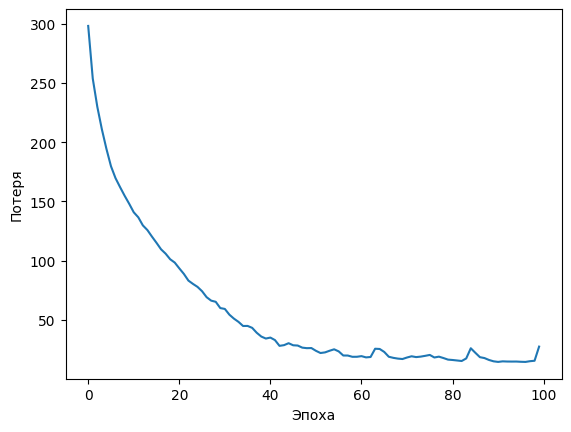

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.show()

In [ ]:
# Проверить работоспособность модели
correct = 0
for X, y in test_loader:
    X = X.to(device)
    y = y.to(device)
    label_pred = net1.forward(X).argmax(dim=1)
    correct += (label_pred == y).sum()

accuracy = correct / len(surnames_dataset_test)
print('значение accuracy на тестовом множестве:', accuracy)

значение accuracy на тестовом множестве: tensor(0.7127, device='cuda:0')


In [ ]:
#gru
n_classes = surnames['nationality class'].nunique()

class SurnamesNet(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(SurnamesNet, self).__init__()
        self.emb = nn.Embedding.from_pretrained(embeddings_surnames)
        self.gru = nn.GRU(input_size=columns, hidden_size=hidden_size, batch_first=True) 
        self.fc = torch.nn.Linear(hidden_size, n_classes)
        
    def forward(self, x):
        x = self.emb(x)
        output, h_n = self.gru(x)
        x = self.fc(output[:, -1])
        return x

In [ ]:
net = SurnamesNet(256, 512)
net = net.to(device)

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

n_epochs = 100
losses = []
for epoch in range(n_epochs):
    loss_value = 0
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        y_pred = net.forward(X)
        loss_tensor = loss.forward(y_pred, y)
        loss_tensor.backward() #градиент
        optimizer.step() #применение градиента
        optimizer.zero_grad()
        loss_value += loss_tensor.item()
    losses.append(loss_value)
    print(f'epoch {epoch} loss {loss_value}')

epoch 0 loss 290.7554486989975
epoch 1 loss 228.84792983531952
epoch 2 loss 197.68473982810974
epoch 3 loss 175.28827995061874
epoch 4 loss 157.38133937120438
epoch 5 loss 143.6804113984108
epoch 6 loss 132.251240670681
epoch 7 loss 121.88329562544823
epoch 8 loss 113.962089240551
epoch 9 loss 106.10971626639366
epoch 10 loss 99.55238291621208
epoch 11 loss 92.15098166465759
epoch 12 loss 86.91747851669788
epoch 13 loss 82.25554564595222
epoch 14 loss 75.78136746585369
epoch 15 loss 69.0919264703989
epoch 16 loss 64.77722090482712
epoch 17 loss 59.906564593315125
epoch 18 loss 54.91014739871025
epoch 19 loss 49.55950402468443
epoch 20 loss 44.79938495159149
epoch 21 loss 40.63127140700817
epoch 22 loss 37.89363020658493
epoch 23 loss 34.74929217994213
epoch 24 loss 32.085287153720856
epoch 25 loss 30.112624518573284
epoch 26 loss 28.26552814617753
epoch 27 loss 27.766968488693237
epoch 28 loss 26.614876989275217
epoch 29 loss 25.466297147795558
epoch 30 loss 24.398621194064617
epoch 31

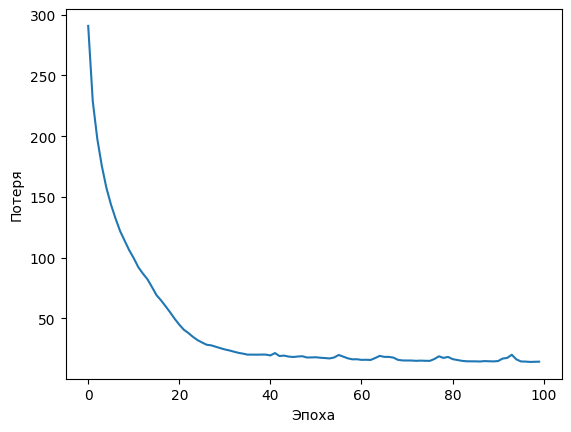

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.show()

In [ ]:
# Проверить работоспособность модели
correct = 0
for X, y in test_loader:
    X = X.to(device)
    y = y.to(device)
    label_pred = net.forward(X).argmax(dim=1)
    correct += (label_pred == y).sum()

accuracy = correct / len(surnames_dataset_test)
print('значение accuracy на тестовом множестве:', accuracy)

значение accuracy на тестовом множестве: tensor(0.7459, device='cuda:0')


## 2. Классификация обзоров на фильмы (RNN)

Датасет: https://disk.yandex.ru/d/tdinpb0nN_Dsrg

2.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.
  * токен = __слово__
  * данные для обучения в датасете представляются в виде последовательности индексов токенов
  * словарь создается на основе _только_ обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен `<UNK>`
  * добавьте предобработку текста

2.2. Обучите классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding` 
    - подберите адекватную размерность вектора эмбеддинга: 
    - модуль `nn.Embedding` обучается

  * Используйте рекуррентные слои (`nn.RNN`, `nn.LSTM`, `nn.GRU`)


2.3 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)
* Целевое значение accuracy на валидации - 70+%

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/polarity/positive_reviews.txt', 'r') as f:
    lines = f.read().splitlines()
negative_reviews = pd.DataFrame({'reviews': lines})
negative_reviews['mark'] = 0
negative_reviews

,reviews,mark
0,"simplistic , silly and tedious .",0
1,"it's so laddish and juvenile , only teenage bo...",0
2,exploitative and largely devoid of the depth o...,0
3,[garbus] discards the potential for pathologic...,0
4,a visually flashy but narratively opaque and e...,0
...,...,...
5326,a terrible movie that some people will neverth...,0
5327,there are many definitions of 'time waster' bu...,0
5328,"as it stands , crocodile hunter has the hurrie...",0
5329,the thing looks like a made-for-home-video qui...,0


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/polarity/negative_reviews.txt', 'r') as f:
    lines = f.read().splitlines()
positive_reviews = pd.DataFrame({'reviews': lines})
positive_reviews['mark'] = 1
positive_reviews

,reviews,mark
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1
...,...,...
5326,both exuberantly romantic and serenely melanch...,1
5327,mazel tov to a film about a family's joyous li...,1
5328,standing in the shadows of motown is the best ...,1
5329,it's nice to see piscopo again after all these...,1


In [ ]:
reviews = pd.concat([positive_reviews, negative_reviews]) #объединяем объекты
reviews

,reviews,mark
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1
...,...,...
5326,a terrible movie that some people will neverth...,0
5327,there are many definitions of 'time waster' bu...,0
5328,"as it stands , crocodile hunter has the hurrie...",0
5329,the thing looks like a made-for-home-video qui...,0


In [ ]:
#Разбить датасет на обучающую и тестовую выборку
X = reviews['reviews']
y = reviews['mark']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

*   токен = слово
*   данные для обучения в датасете представляются в виде последовательности индексов токенов
*   словарь создается на основе только обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен
*   добавьте предобработку текста



In [ ]:
# класс который предоставляет словарные объекты для обработки естественного языка
class Vocab:
    def __init__(self, data):
        self.token_to_idx = {'<PAD>': 0, '<UNK>': 1} 
        index = 2
        stop_words = stopwords.words()
        for review in data:
            review = review.lower()
            words = word_tokenize(review) 
            for word in words:
                if word not in '''!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~``''' and word not in stop_words:
                    if word not in self.token_to_idx:
                        self.token_to_idx[word] = index
                        index += 1
        self.vocab_len = index

In [ ]:
nltk.download('stopwords')
vocabulary = Vocab(X_train)
vocabulary.token_to_idx['actors']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


797

In [ ]:
vocabulary.vocab_len

17535

In [ ]:
#2.5 Реализовать класс ReviewsDataset
class ReviewsDataset(Dataset):
    def __init__(self, X, y, vocab: Vocab):
        self.X = X
        self.y = y
        self.vocab = vocab
        self.stop_words = stopwords.words()

    def vectorize(self, review):
        indexes = []
        pad_index = self.vocab.token_to_idx['<PAD>'] #тут 0
        unk_index = self.vocab.token_to_idx['<UNK>'] #тут 1
        review = review.lower()
        words = word_tokenize(review) 
        for word in words:
            if word not in '''!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~--''' and word not in self.stop_words:
                if word in self.vocab.token_to_idx:
                    index = self.vocab.token_to_idx[word]
                else:
                    index = unk_index
                indexes.append(index)
        count_pad = 40 - len(indexes) #длина каждой такой последовательности должна быть одинаковой и равной 40
        for i in range(count_pad): #Чтобы добиться этого, дополните последовательность справа индексом токена <PAD> до нужной длины
            indexes.append(pad_index) #добавляем в конец списка элемент, переданный ему в качестве аргумента
        return indexes[:40]
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx): #метод __getitem__ возвращает пару: <последовательность индексов токенов (см. 1.1 ), номер класса>
        x_review = torch.tensor(self.vectorize(self.X.iloc[idx]))
        y_review = torch.tensor(self.y.iloc[idx])
        return (x_review, y_review)

In [ ]:
reviews_dataset_train = ReviewsDataset(X_train, y_train, vocabulary)
reviews_dataset_test = ReviewsDataset(X_test, y_test, vocabulary)

In [ ]:
print(reviews_dataset_train.X.iloc[0])
reviews_dataset_train[0]

a refreshingly honest and ultimately touching tale of the sort of people usually ignored in contemporary american film . search it out .


(tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0]),
 tensor(1))

In [ ]:
batch_size = 64
train_loader = DataLoader(reviews_dataset_train, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(reviews_dataset_test, shuffle=True, batch_size=batch_size)

Двунаправленные рекуррентные нейронные сети (Bidirectional RNNs) основаны на той идее, что выход в момент времени t может зависеть не только от предыдущих элементов в последовательности, но и от будущих. Например, если вы хотите предсказать недостающее слово в последовательности, учитывая как в левый, так и в правый контекст.



In [ ]:
#lstm
n_classes = 2

class ReviewsNet(nn.Module):
    def __init__(self, embedding_dim, hidden_size, n_hidden_neurons):
        super(ReviewsNet, self).__init__()
        self.emb = nn.Embedding(num_embeddings=vocabulary.vocab_len, embedding_dim=embedding_dim)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True, num_layers=2, bidirectional=True) #двунаправленность 
        self.fc = torch.nn.Linear(hidden_size * 2, n_hidden_neurons)
        self.act = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_classes)
        
    def forward(self, x):
        x = self.emb(x)
        output, h_n = self.gru(x)
        x = self.fc(output[:, -1])
        x = self.act(x)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

In [ ]:
net = ReviewsNet(256, 512, 512)
net = net.to(device)

In [ ]:
class Transpose(nn.Module):
    def forward(self, X):
        return X.transpose(2, 1)

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
#lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

n_epochs = 25
losses = []
for epoch in range(n_epochs):
    loss_value = 0
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        y_pred = net.forward(X)
        loss_tensor = loss.forward(y_pred, y)
        loss_tensor.backward() #градиент
        optimizer.step() #применение градиента
        optimizer.zero_grad()
        loss_value += loss_tensor.item()
    #lr_scheduler.step()
    losses.append(loss_value)
    print(f'epoch {epoch} loss {loss_value}')

epoch 0 loss 93.3548434972763
epoch 1 loss 92.71628159284592
epoch 2 loss 83.05829131603241
epoch 3 loss 58.346734285354614
epoch 4 loss 29.516428716480732
epoch 5 loss 11.306644248776138
epoch 6 loss 5.0164169676136225
epoch 7 loss 3.5579394655651413
epoch 8 loss 2.916513828356983
epoch 9 loss 1.7038973179005552
epoch 10 loss 2.4912264549348038
epoch 11 loss 1.5275209018072928
epoch 12 loss 1.0299767187589168
epoch 13 loss 1.0590663489347207
epoch 14 loss 1.4044218386043212
epoch 15 loss 0.9462017440484942
epoch 16 loss 0.2777925863817927
epoch 17 loss 0.07307740214446312
epoch 18 loss 0.05886199484575627
epoch 19 loss 0.0874688873393552
epoch 20 loss 0.058718499278256786
epoch 21 loss 0.06189336158601577
epoch 22 loss 0.05107905609507579
epoch 23 loss 0.07724845122959323
epoch 24 loss 0.07089138196033673


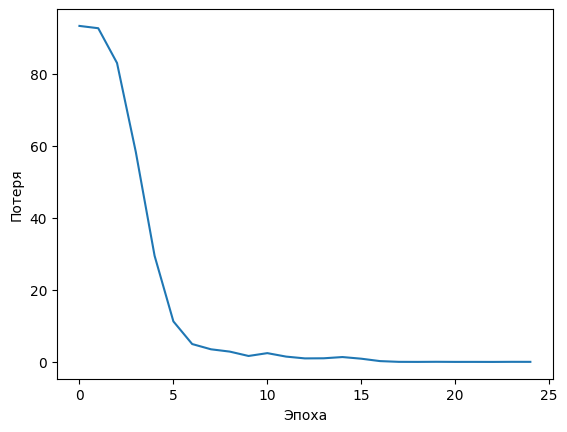

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.show()

In [ ]:
# Проверить работоспособность модели
correct = 0
for X, y in test_loader:
    X = X.to(device)
    y = y.to(device)
    label_pred = net.forward(X).argmax(dim=1)
    correct += (label_pred == y).sum()

accuracy = correct / len(reviews_dataset_test)
print('значение accuracy на тестовом множестве:', accuracy)

значение accuracy на тестовом множестве: tensor(0.7089, device='cuda:0')


In [ ]:
mark = [1, 0]
reviews = ['It is a great movie. The whole family laughed. I recommend it to my friends. The actors are super', 'Not interesting. Disgusting. No one will watch it. Terrible, boring, bad']
test_reviews = pd.DataFrame(list(zip(mark, reviews)),
               columns =['mark', 'reviews'])
test_reviews

,mark,reviews
0,1,It is a great movie. The whole family laughed....
1,0,Not interesting. Disgusting. No one will watch...


In [ ]:
X_test_reviews = test_reviews['reviews']
y_test_reviews = test_reviews['mark']
test_reviews_dataset = ReviewsDataset(X_test_reviews, y_test_reviews, vocabulary)

predictions = []

for X_test_reviews, y_test_reviews in test_reviews_dataset:
    X_test_reviews = X_test_reviews.to(device).reshape(1, -1)
    y_test_reviews = y_test_reviews.to(device)
    y_pred = net.forward(X_test_reviews)[0].argmax()
    predictions.append(y_pred.cpu())

predictions = np.array(predictions)
test_reviews['predicted reviews'] = predictions
test_reviews

,mark,reviews,predicted reviews
0,1,It is a great movie. The whole family laughed....,1
1,0,Not interesting. Disgusting. No one will watch...,0
